## 1. <Directed Acyclic Graph 구현을 위한 데이터 전처리 코드>

###   1) 총 시뮬레이션 시간 동안의 노드 간 연기 이동 방향 분석
- Stationary dBN
- Non-stationary dBN

#### (1) 노드 간 연기 이동 전처리 -> 데이터 프레임화

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import IPython

In [2]:
# node(Labelized Variable)별 space aim number(xml space name) -> node numbering dictionary
xml2node_code = {'3252':'r1', '3300':'r2', '3348':'r3', '3396':'r4', '3344':'r5', '3492':'r6',
               '2594':'r7', '2642':'r8', '2695':'r9', '1715':'r10', '1773':'r11', '0390':'r12',
               '0438':'r13', '0491':'r14', '3093':'r15', '3151':'r16', '3204':'r17', '1836':'r18', 
               '1899':'r19', '0909':'r20', '0967':'r21', '1020':'r22', '0080':'r23', '0193':'r24', 
                '0241':'r25', '0294':'r26', '0342':'r27', '2154':'r28', '1275':'r29', '2435':'r30',
               '1556':'r31', '2207':'r32', '2260':'r33', '2313':'r34', '1328':'r35', '1381':'r36',
               '1434':'r37', '2753':'r38', '2806':'r39', '2870':'r40', '2923':'r41', '2976':'r42',
               '3040':'r43', '1947':'r44', '2000':'r45', '1068':'r46', '1121':'r47', '2488':'r48',
               '2541':'r49', '1609':'r50', '1662':'r51', '0549':'r52', '0602':'r53', '0676':'r54',
               '0729':'r55', '0782':'r56', '0856':'r57', '2058':'r58', '3540':'r59', '1179':'r60',
               '3609':'r61', '2366':'r62', '3678':'r63', '1487':'r64', '3774':'r65'}

df_mafldensity_raw = pd.read_csv('d.massfluxdensity/analysis_md_aim2870.csv', encoding='utf-8')
# df_mafldensity_raw: 각 time 당 두 room 사이의 mass flux density 이동량
df_mafldensity_raw['Time'] = df_mafldensity_raw['Time'].map(lambda x: int(str(x).split('.')[0])) # time column 소숫점 자리 제거

# raw dataframe melting : [Time] column data -> id_vars, column에 있는 variables -> var_name, 기존데이터 value값 -> MassFluxDensity(kg/s)
df_mafldensity_raw = df_mafldensity_raw.melt(id_vars=['Time'], var_name = 'roomij(i_j)', value_name = 'MassFluxDensity(kg/s)')

In [3]:
# roomij(i_j)에 있는 값을 '_'로 전부 분리해서 정리
df_mafldensity_raw['room i'] = df_mafldensity_raw['roomij(i_j)'].map(lambda x: str(x).split('_')[1])
df_mafldensity_raw['room j'] = df_mafldensity_raw['roomij(i_j)'].map(lambda x: str(x).split('_')[2])
df_mafldensity_raw = df_mafldensity_raw.drop('roomij(i_j)', axis = 1)
df_mafldensity_raw.replace({'room i':xml2node_code}, inplace = True)
df_mafldensity_raw.replace({'room j':xml2node_code}, inplace = True)

In [4]:
df_mafldensity_raw

,Time,MassFluxDensity(kg/s),room i,room j
0,0,0.000000,r7,r44
1,1,0.000000,r7,r44
2,2,0.000000,r7,r44
3,3,0.000000,r7,r44
4,4,0.000000,r7,r44
...,...,...,...,...
29995,395,0.000389,r50,r51
29996,396,0.000394,r50,r51
29997,397,0.000390,r50,r51
29998,398,0.000381,r50,r51


In [5]:
# 총 시뮬레이션 시간 동안 space 간 연기 이동이 없는 경우가 있는지 확인
df_Smafldensity = df_mafldensity_raw.groupby(by=['room i', 'room j']).sum().reset_index()
if len(df_Smafldensity[df_Smafldensity['MassFluxDensity(kg/s)'] == 0]) == 0:
    pass
else:
    print(len(df_Smafldensity[df_Smafldensity['MassFluxDensity(kg/s)'] == 0]))

In [6]:
df_mafldensity_raw

,Time,MassFluxDensity(kg/s),room i,room j
0,0,0.000000,r7,r44
1,1,0.000000,r7,r44
2,2,0.000000,r7,r44
3,3,0.000000,r7,r44
4,4,0.000000,r7,r44
...,...,...,...,...
29995,395,0.000389,r50,r51
29996,396,0.000394,r50,r51
29997,397,0.000390,r50,r51
29998,398,0.000381,r50,r51


In [7]:
# dataframe 정리
df_mafldensity_raw['room ini'], df_mafldensity_raw['room fin'] = "", ""
df_mafldensity_raw

,Time,MassFluxDensity(kg/s),room i,room j,room ini,room fin
0,0,0.000000,r7,r44,,
1,1,0.000000,r7,r44,,
2,2,0.000000,r7,r44,,
3,3,0.000000,r7,r44,,
4,4,0.000000,r7,r44,,
...,...,...,...,...,...,...
29995,395,0.000389,r50,r51,,
29996,396,0.000394,r50,r51,,
29997,397,0.000390,r50,r51,,
29998,398,0.000381,r50,r51,,


#### (2) 노드 간 연기 이동 "방향" 판단 -> 데이터 프레임 column 추가: 출발 room - [room ini], 도착 room - [room fin]
- relationship modeling.xlsx - room간 방향성을 모델링한 파일
- 예를 들어, r65가 r57보다 위에 있기 때문에, massfluxdensity값이 양수이면 massflux가 일어난 방향이 r57 -> r65임.
- 이것은 DAG 결정에 있어 중요한 증거이기 때문에 분석에 추가하였음.
- 같은 room들 간 이동이어도 매초마다 양수일 수도 음수일 수도 있으므로 더 우세한 쪽의 방향을 따르는 것이 맞음.

###### 이를 위해서 분석 자동화 코드는 다음을 포함한다.
   1) 같은 room들 간 이동에서, massfluxdensity가 양수인 경우의 수와 음수인 경우의 수를 세어 비교
   2) sum값의 부호가 1)의 우세한 부호와 일지하는지 확인

In [8]:
room_relation = pd.read_csv('d.others/relationship_modeling.csv', encoding='utf-8')

index_name = []
for colname in room_relation.columns[:]:
    index_name.append('r{}'.format(colname))
    room_relation.rename(columns = {colname:'r{}'.format(colname)}, inplace=True)

room_relation.index = pd.Series(index_name)

In [9]:
room_relation = room_relation.replace('-', np.nan)
room_relation

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r10,...,r56,r57,r58,r59,r60,r61,r62,r63,r64,r65
r1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
r2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
r3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
r4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
r5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
r61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1,-1,NaN,NaN,NaN,NaN,NaN
r62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,-1,NaN
r63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,-1
r64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,1


In [10]:
# room_relation 데이터 프레임에서 room과의 관계를 읽어, 정리된 df_mafldensity_raw 데이터 프레임에 적용
# 매초(time) 별로 어느 room에서 어떤 room으로 매연입자가 확산하는지를 판단하여 새 컬럼에 기록
df_mafldensity_values_list = df_mafldensity_raw.values.tolist()

for x in df_mafldensity_values_list:
    values_index = df_mafldensity_values_list.index(x)
    
    if int(room_relation.loc[x[2], x[3]]) * x[1] > 0:
        df_mafldensity_raw.loc[values_index, 'room ini'] = x[2]
        df_mafldensity_raw.loc[values_index, 'room fin'] = x[3]
        
    elif int(room_relation.loc[x[2], x[3]]) * x[1] < 0:
        df_mafldensity_raw.loc[values_index, 'room ini'] = x[3]
        df_mafldensity_raw.loc[values_index, 'room fin'] = x[2]
        
    else:
        df_mafldensity_raw.loc[values_index, 'room ini'] = np.nan
        df_mafldensity_raw.loc[values_index, 'room fin'] = np.nan

df_mafldensity_raw

,Time,MassFluxDensity(kg/s),room i,room j,room ini,room fin
0,0,0.000000,r7,r44,NaN,NaN
1,1,0.000000,r7,r44,NaN,NaN
2,2,0.000000,r7,r44,NaN,NaN
3,3,0.000000,r7,r44,NaN,NaN
4,4,0.000000,r7,r44,NaN,NaN
...,...,...,...,...,...,...
29995,395,0.000389,r50,r51,r50,r51
29996,396,0.000394,r50,r51,r50,r51
29997,397,0.000390,r50,r51,r50,r51
29998,398,0.000381,r50,r51,r50,r51


In [11]:
# 전처리된 room 간 연기 이동 데이터프레임 -> out
df_mafldensity_tidy = df_mafldensity_raw.copy()
df_mafldensity_tidy.to_csv("r.preprocessed/2870(40).csv")

df_mafldensity_tidy['room i_j'] = df_mafldensity_tidy['room i']+'_'+df_mafldensity_tidy['room j']
df_mafldensity_tidy.drop(columns=['room i', 'room j'], inplace = True)
df_mafldensity_tidy['room ini_fin'] = df_mafldensity_tidy['room ini']+'_'+df_mafldensity_tidy['room fin']
df_mafldensity_tidy.drop(columns=['room ini', 'room fin'], inplace = True)

In [12]:
df_mafldensity_tidy

,Time,MassFluxDensity(kg/s),room i_j,room ini_fin
0,0,0.000000,r7_r44,NaN
1,1,0.000000,r7_r44,NaN
2,2,0.000000,r7_r44,NaN
3,3,0.000000,r7_r44,NaN
4,4,0.000000,r7_r44,NaN
...,...,...,...,...
29995,395,0.000389,r50_r51,r50_r51
29996,396,0.000394,r50_r51,r50_r51
29997,397,0.000390,r50_r51,r50_r51
29998,398,0.000381,r50_r51,r50_r51


In [13]:
grouped=df_mafldensity_tidy.groupby(['room i_j', 'room ini_fin']).count()
grouped.reset_index(level=['room i_j', 'room ini_fin'], inplace = True)
list_grouped_values = grouped.values.tolist()

In [14]:
list_grouped_values

[['r10_r46', 'r10_r46', 43, 43],
 ['r10_r46', 'r46_r10', 168, 168],
 ['r11_r47', 'r47_r11', 237, 237],
 ['r15_r48', 'r48_r15', 297, 297],
 ['r16_r49', 'r49_r16', 286, 286],
 ['r17_r49', 'r49_r17', 287, 287],
 ['r1_r38', 'r38_r1', 326, 326],
 ['r20_r50', 'r50_r20', 221, 221],
 ['r21_r51', 'r51_r21', 226, 226],
 ['r23_r52', 'r52_r23', 282, 282],
 ['r27_r57', 'r57_r27', 280, 280],
 ['r29_r60', 'r60_r29', 266, 266],
 ['r2_r39', 'r39_r2', 322, 322],
 ['r30_r63', 'r63_r30', 328, 328],
 ['r31_r65', 'r65_r31', 254, 254],
 ['r32_r40', 'r32_r40', 45, 45],
 ['r32_r40', 'r40_r32', 303, 303],
 ['r33_r40', 'r33_r40', 53, 53],
 ['r33_r40', 'r40_r33', 299, 299],
 ['r34_r41', 'r41_r34', 328, 328],
 ['r35_r54', 'r54_r35', 248, 248],
 ['r36_r54', 'r54_r36', 240, 240],
 ['r37_r55', 'r55_r37', 237, 237],
 ['r38_r39', 'r39_r38', 366, 366],
 ['r38_r58', 'r38_r58', 357, 357],
 ['r39_r40', 'r40_r39', 383, 383],
 ['r39_r59', 'r39_r59', 364, 364],
 ['r3_r40', 'r40_r3', 361, 361],
 ['r40_r41', 'r40_r41', 383, 383

In [15]:
smoke_move_relation = []
for li in range(len(list_grouped_values)+1):
    if li+1 < len(list_grouped_values):
        list_this_turn = list_grouped_values[li]
        list_next_turn = list_grouped_values[li+1]
        
        if list_this_turn[0] == list_next_turn[0]:
            if list_this_turn[2] > list_next_turn[2]:
                smoke_move_relation.append(list_this_turn[1])
            elif list_this_turn[2] < list_next_turn[2]:
                smoke_move_relation.append(list_next_turn[1])
            else:
                smoke_move_relation.append('identical')
        
        else:
            reverse_list_this_turn = list_this_turn[1].split('_')[1] + '_' + list_this_turn[1].split('_')[0]
            if smoke_move_relation.count(list_this_turn[1]) == 0 and smoke_move_relation.count(reverse_list_this_turn) == 0:
                if smoke_move_relation[-1] != list_this_turn[0]:
                    smoke_move_relation.append(list_this_turn[1])
                
                    if (list_next_turn == list_grouped_values[-1]) and (smoke_move_relation.count(list_next_turn[1]) == 0):
                        smoke_move_relation.append(list_next_turn[1])

len(smoke_move_relation)

75

In [16]:
pair_of_smr = [tuple(x.split('_')) for x in smoke_move_relation]
pair_of_smr0 = [tuple (y+'_0' for y in tuple(x.split('_'))) for x in smoke_move_relation]
pair_of_smrt = [tuple (y+'_t' for y in tuple(x.split('_'))) for x in smoke_move_relation]

In [17]:
pair_of_smr

[('r46', 'r10'),
 ('r47', 'r11'),
 ('r48', 'r15'),
 ('r49', 'r16'),
 ('r49', 'r17'),
 ('r38', 'r1'),
 ('r50', 'r20'),
 ('r51', 'r21'),
 ('r52', 'r23'),
 ('r57', 'r27'),
 ('r60', 'r29'),
 ('r39', 'r2'),
 ('r63', 'r30'),
 ('r65', 'r31'),
 ('r40', 'r32'),
 ('r40', 'r33'),
 ('r41', 'r34'),
 ('r54', 'r35'),
 ('r54', 'r36'),
 ('r55', 'r37'),
 ('r39', 'r38'),
 ('r38', 'r58'),
 ('r40', 'r39'),
 ('r39', 'r59'),
 ('r40', 'r3'),
 ('r40', 'r41'),
 ('r41', 'r42'),
 ('r42', 'r43'),
 ('r42', 'r62'),
 ('r43', 'r63'),
 ('r44', 'r10'),
 ('r45', 'r44'),
 ('r45', 'r11'),
 ('r58', 'r45'),
 ('r46', 'r12'),
 ('r46', 'r13'),
 ('r47', 'r46'),
 ('r47', 'r14'),
 ('r60', 'r47'),
 ('r48', 'r18'),
 ('r48', 'r49'),
 ('r49', 'r19'),
 ('r41', 'r4'),
 ('r50', 'r18'),
 ('r50', 'r51'),
 ('r19', 'r51'),
 ('r51', 'r22'),
 ('r52', 'r53'),
 ('r60', 'r52'),
 ('r53', 'r54'),
 ('r61', 'r53'),
 ('r54', 'r24'),
 ('r54', 'r55'),
 ('r55', 'r25'),
 ('r56', 'r55'),
 ('r56', 'r26'),
 ('r57', 'r56'),
 ('r58', 'r28'),
 ('r59', 'r58'),
 

#### (3) 노드 간 연기 이동 "방향"으로 시각화 -> DAG 결정

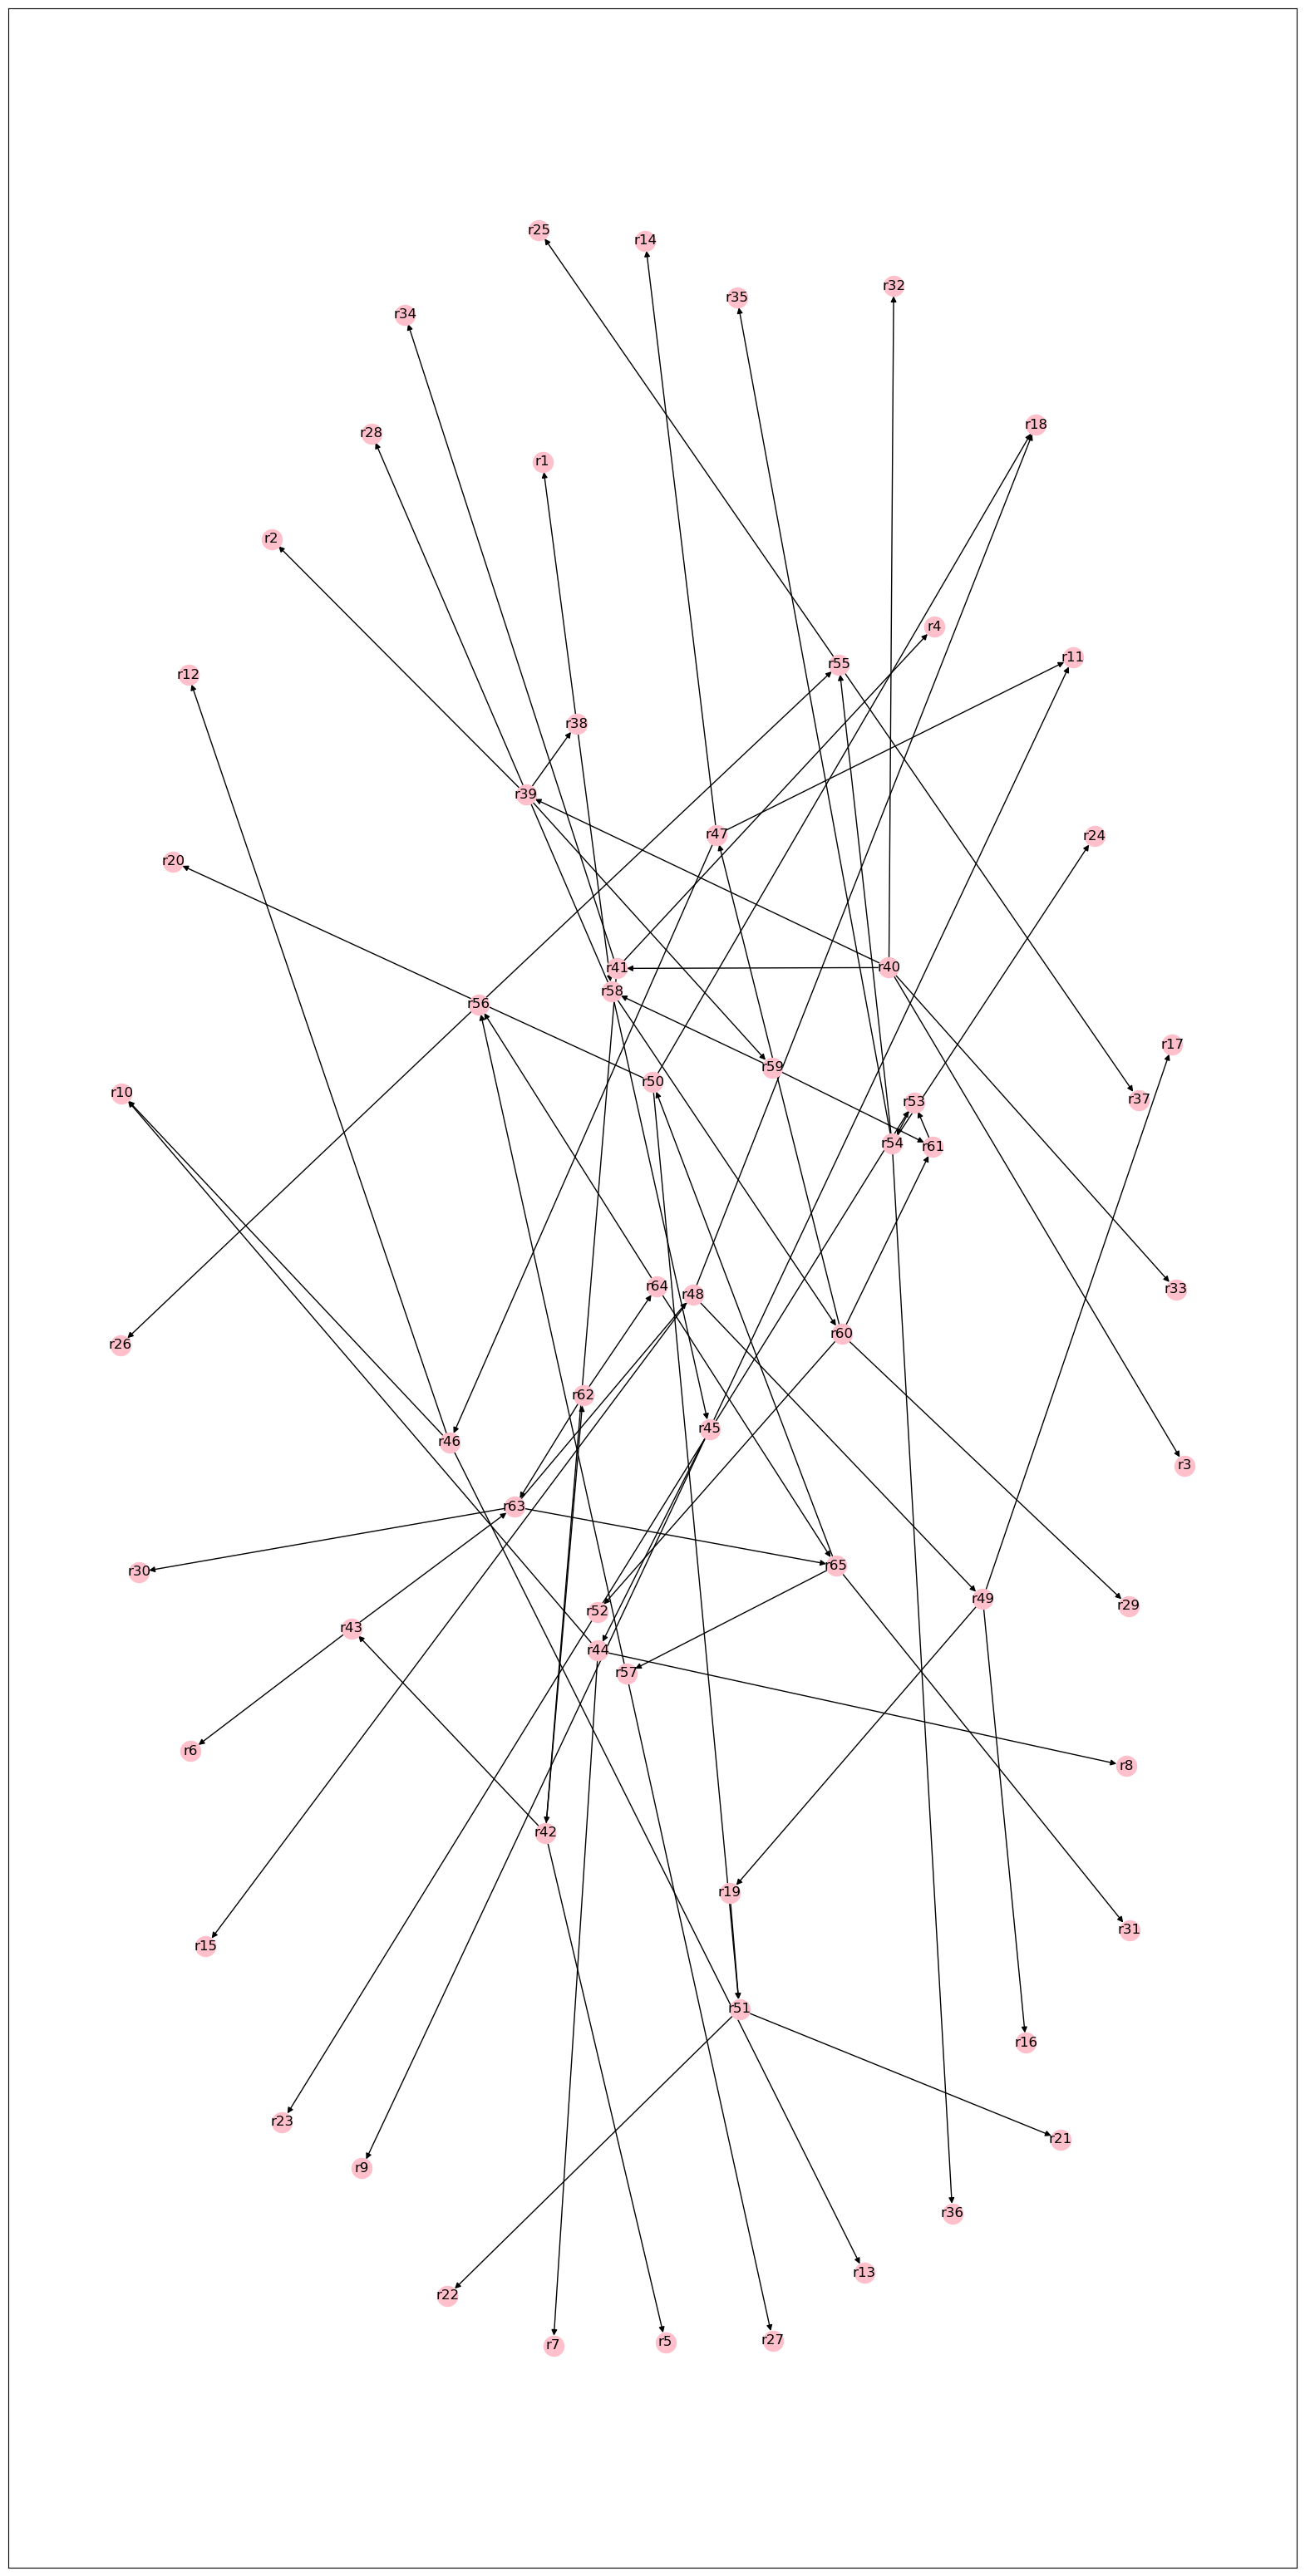

In [18]:
figures = []
plt.figure(figsize=(20,40))
G = nx.DiGraph()
G.add_edges_from(pair_of_smr)
nx.draw_networkx(G, arrows = True, node_color = 'pink')
figures.append(G)
plt.savefig('r.dag/2870(40).png')

## 2. <PyArgum 라이브러리를 이용한 동적 베이지안 네트워크 구현>

###   1) unStationary dBN (nsDBN)
 - DAG 유지, 확률변화 (CPT 변화 DBN만들기)

In [19]:
from datetime import datetime
now = datetime.now()

print("현재 : ", now)
print("현재 날짜 : ", now.date())
print("현재 시간 : ", now.time())
print("timestamp : ", now.timestamp())
print("년 : ", now.year)
print("월 : ", now.month)
print("일 : ", now.day)
print("시 : ", now.hour)
print("분 : ", now.minute)
print("초 : ", now.second)
print("마이크로초 : ", now.microsecond)
print("요일 : ", now.weekday())
print("문자열 변환 : ", now.strftime('%Y-%m-%d %H:%M:%S'))

현재 :  2023-11-23 19:26:12.201990
현재 날짜 :  2023-11-23
현재 시간 :  19:26:12.201990
timestamp :  1700735172.20199
년 :  2023
월 :  11
일 :  23
시 :  19
분 :  26
초 :  12
마이크로초 :  201990
요일 :  3
문자열 변환 :  2023-11-23 19:26:12


In [20]:
import pyAgrum as gum
import pyAgrum.lib.dynamicBN as gdyn
import pyAgrum.lib.notebook as gnb

In [21]:
dag_dBN = gum.BayesNet('2870(40)')
dag_nodes = list(G.nodes)
dBN_nodes = []

for node in dag_nodes:
    globals()[node+'_0'] = dag_dBN.add(gum.LabelizedVariable(node+'_0',node+'_0',2))
    globals()[node+'_t'] = dag_dBN.add(gum.LabelizedVariable(node+'_t',node+'_t',2))
    dBN_nodes.append(node+'_0')
    dBN_nodes.append(node+'_t')

In [22]:
pair_of_self = [(node+'_0', node+'_t') for node in dag_nodes]
for link in pair_of_smr0:
    dag_dBN.addArc(*link)

print(dag_dBN)

for link in pair_of_smrt:
    dag_dBN.addArc(*link)

print(dag_dBN)

for link in pair_of_self:
    dag_dBN.addArc(*link)

BN{nodes: 130, arcs: 75, domainSize: 10^39.1339, dim: 216, mem: 3Ko 384o}
BN{nodes: 130, arcs: 150, domainSize: 10^39.1339, dim: 302, mem: 4Ko 736o}


In [23]:
for i in dBN_nodes:
    print(dag_dBN.cpt(i))


      ||  r46_0            |
r47_0 ||0        |1        |
------||---------|---------|
0     || 0.0000  | 0.0000  |
1     || 0.0000  | 0.0000  |


             ||  r46_t            |
r47_t |r46_0 ||0        |1        |
------|------||---------|---------|
0     |0     || 0.0000  | 0.0000  |
1     |0     || 0.0000  | 0.0000  |
0     |1     || 0.0000  | 0.0000  |
1     |1     || 0.0000  | 0.0000  |


             ||  r10_0            |
r46_0 |r44_0 ||0        |1        |
------|------||---------|---------|
0     |0     || 0.0000  | 0.0000  |
1     |0     || 0.0000  | 0.0000  |
0     |1     || 0.0000  | 0.0000  |
1     |1     || 0.0000  | 0.0000  |


                    ||  r10_t            |
r46_t |r44_t |r10_0 ||0        |1        |
------|------|------||---------|---------|
0     |0     |0     || 0.0000  | 0.0000  |
1     |0     |0     || 0.0000  | 0.0000  |
0     |1     |0     || 0.0000  | 0.0000  |
1     |1     |0     || 0.0000  | 0.0000  |
0     |0     |1     || 0.0000  | 0.0000  |


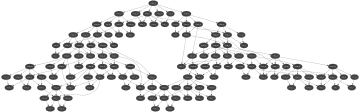

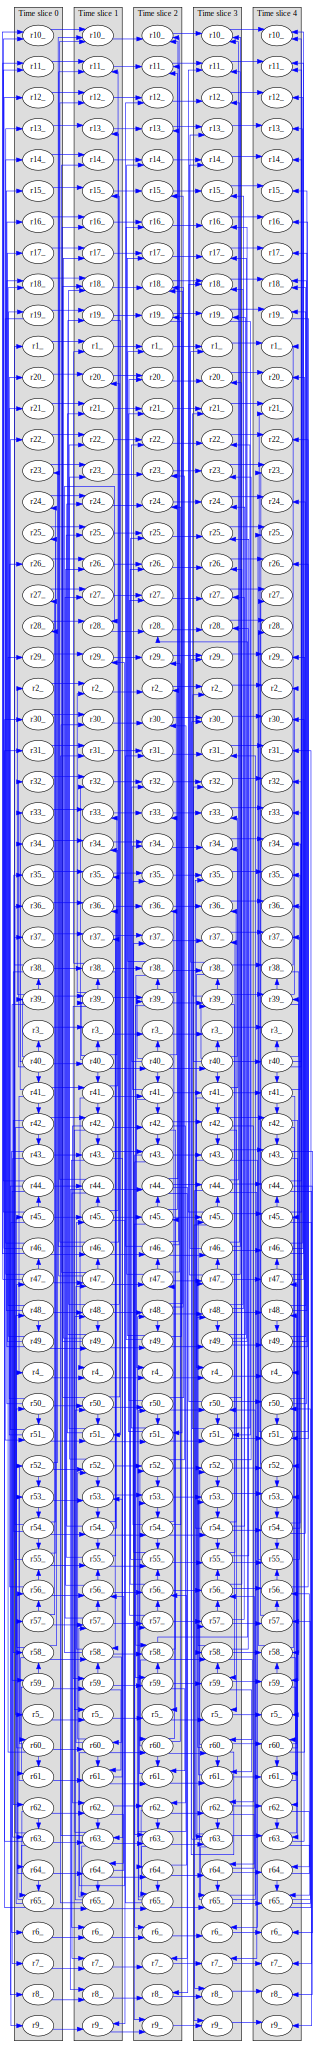

In [24]:
T = 5

gnb.showBN(dag_dBN)

ftts_dbn = gdyn.unroll2TBN(dag_dBN, T)
gdyn.showTimeSlices(ftts_dbn, size="30")

In [25]:
ftts_dbn_nodes = ftts_dbn.names()
ts_0 = sorted([e for e in ftts_dbn_nodes
          if (int(e.split('_')[1]) == 0)])
ts_1 = sorted([e for e in ftts_dbn_nodes
          if (int(e.split('_')[1]) in range(1, 2))])
ts_2 = sorted([e for e in ftts_dbn_nodes
          if (int(e.split('_')[1]) in range(2, 3))])
ts_3 = sorted([e for e in ftts_dbn_nodes
          if (int(e.split('_')[1]) in range(3, 4))])
ts_4 = sorted([e for e in ftts_dbn_nodes
          if (int(e.split('_')[1]) in range(4, 5))])

### 2) CPT timeslice별 리스트 작성 (CPT_calculation_template_EXP.xlsx 템플릿 이용)

####  (1) CPT를 엑셀 템플릿으로 계산할 때는 총 400초의 simulation time을 100초 단위로 끊어 네 구간에서 계산
####  (2) pyAgrum을 이용한 dBN을 만들 때에는 400초를 8구간으로 나누어 생각함. (50s로 단위로 끊은 후 두 구간씩 같은 list를 사용한다.)

In [26]:
cpt_0 = [[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[1, 0],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000]]

cpt_1= [[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.4604,0.0000,0.0000,1.0000,0.4604,0.5396,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.4605,0.5395,0.0000,1.0000,0.4605,0.5395,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.4468,0.5532,0.0000,1.0000,0.4468,0.5532,0.0000,1.0000],[0.4465,0.5535,0.0000,1.0000,0.4465,0.5535,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.6391,0.3609,0.0000,1.0000,0.6391,0.3609,0.0000,1.0000],[0.9711,0.0289,0.0000,1.0000,0.9711,0.0289,0.0000,1.0000],[0.4410,0.5590,0.0000,1.0000,0.4410,0.5590,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[1.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,1.0000],[1.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,1.0000],[0.9145,0.0855,0.0000,1.0000,0.9145,0.0855,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[1.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,1.0000],[1.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,1.0000],[1.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,1.0000],[0.5895,0.4105,0.0000,1.0000,0.5895,0.4105,0.0000,1.0000],[0.7992,0.2008,0.0000,1.0000,0.7992,0.2008,0.0000,1.0000],[0.7952,0.2048,0.0000,1.0000,0.7952,0.2048,0.0000,1.0000],[1.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,1.0000],[0.6665,0.3335,0.0000,1.0000,0.6665,0.3335,0.0000,1.0000],[0.4846,0.5154,0.0000,1.0000,0.4846,0.5154,0.0000,1.0000],[0.8864,0.1136,0.0000,1.0000,0.8864,0.1136,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.5172,0.4828,0.0000,1.0000,0.5172,0.4828,0.0000,1.0000],[0.2718,0.7282,0.2718,0.7282,0.0000,1.0000,0.0000,1.0000,0.2718,0.7282,0.2718,0.7282,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.4674,0.5326,0.0000,1.0000,0.4674,0.5326,0.0000,1.0000],[1.0000,0.0000,0.7559,0.2441,0.7699,0.2301,0.0000,1.0000,1.0000,0.0000,0.7559,0.2441,0.7699,0.2301,0.0000,1.0000],[1.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,1.0000],[0.5028,0.4972,0.0000,1.0000,0.5028,0.4972,0.0000,1.0000],[0.6863,0.3137,0.0000,1.0000,0.6863,0.3137,0.0000,1.0000],[0.4372,0.5628,0.0000,1.0000,0.4372,0.5628,0.0000,1.0000,0.4372,0.5628,0.0000,1.0000,0.4372,0.5628,0.0000,1.0000],[0.8848,0.1152,0.0000,1.0000,0.8848,0.1152,0.0000,1.0000],[1.0000,0.0000,0.4509,0.5491,0.5491,0.4509,0.0000,1.0000,1.0000,0.0000,0.4509,0.5491,0.5491,0.4509,0.0000,1.0000],[0.5042,0.4958,0.0000,1.0000,0.5042,0.4958,0.0000,1.0000],[0.3331,0.6669,0.0013,0.9987,0.9897,0.0103,0.0013,0.9987,0.3331,0.6669,0.0000,1.0000,0.9884,0.0116,0.0000,1.0000],[0.3671,0.6329,0.0000,1.0000,0.3671,0.6329,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.3924,0.6076,0.0000,1.0000,0.3924,0.6076,0.0000,1.0000]]

cpt_2 = [[1.0000,0.0000,0.8957,0.1043,0.6161,0.3839,0.5118,0.4882,0.4882,0.5118,0.3839,0.6161,0.1043,0.8957,0.0000,1.0000],[1.0000,0.0000,0.7618,0.2382,0.7617,0.2383,0.5236,0.4764,0.4764,0.5236,0.2383,0.7617,0.2382,0.7618,0.0000,1.0000],[0.4126,0.5874,0.0000,1.0000,0.4126,0.5874,0.0000,1.0000],[0.4174,0.5826,0.0000,1.0000,0.4174,0.5826,0.0000,1.0000],[0.3974,0.6026,0.0000,1.0000,0.3974,0.6026,0.0000,1.0000],[1.0000,0.0000,0.4678,0.5322,0.5322,0.4678,0.0000,1.0000],[0.6272,0.3728,0.0000,1.0000,0.6272,0.3728,0.0000,1.0000],[0.5924,0.4076,0.0000,1.0000,0.5924,0.4076,0.0000,1.0000],[1.0000,0.0000,0.7236,0.2764,0.7627,0.2373,0.4863,0.5137,0.5137,0.4863,0.2373,0.7627,0.2764,0.7236,0.0000,1.0000],[0.6440,0.3560,0.0000,1.0000,0.6440,0.3560,0.0000,1.0000],[1.0000,0.0000,0.6778,0.3222,0.3222,0.6778,0.0000,1.0000],[0.5112,0.4888,0.0000,1.0000,0.5112,0.4888,0.0000,1.0000],[0.4066,0.5934,0.0000,1.0000,0.4066,0.5934,0.0000,1.0000],[0.3720,0.6280,0.0000,1.0000,0.3720,0.6280,0.0000,1.0000],[0.6292,0.3708,0.0000,1.0000,0.6292,0.3708,0.0000,1.0000],[0.3740,0.6260,0.0000,1.0000,0.3740,0.6260,0.0000,1.0000],[0.3836,0.6164,0.0000,1.0000,0.3836,0.6164,0.0000,1.0000],[0.5199,0.4801,0.0000,1.0000,0.5199,0.4801,0.0000,1.0000],[0.5683,0.4317,0.0000,1.0000,0.5683,0.4317,0.0000,1.0000],[1.0000,0.0000,0.6919,0.3081,0.3081,0.6919,0.0000,1.0000],[0.5090,0.4910,0.0000,1.0000,0.5090,0.4910,0.0000,1.0000],[1.0000,0.0000,0.7109,0.2891,0.2891,0.7109,0.0000,1.0000],[1.0000,0.0000,0.6414,0.3586,0.3586,0.6414,0.0000,1.0000],[0.4517,0.5483,0.0000,1.0000,0.4517,0.5483,0.0000,1.0000],[1.0000,0.0000,0.8254,0.1746,0.1746,0.8254,0.0000,1.0000],[1.0000,0.0000,0.7207,0.2793,0.2793,0.7207,0.0000,1.0000],[1.0000,0.0000,0.8113,0.1887,0.1887,0.8113,0.0000,1.0000],[0.4706,0.5294,0.0000,1.0000,0.4706,0.5294,0.0000,1.0000],[0.4348,0.5652,0.0000,1.0000,0.4348,0.5652,0.0000,1.0000],[0.4149,0.5851,0.0000,1.0000,0.4149,0.5851,0.0000,1.0000],[1.0000,0.0000,0.6318,0.3682,0.3682,0.6318,0.0000,1.0000],[1.0000,0.0000,0.7654,0.2346,0.2346,0.7654,0.0000,1.0000],[1.0000,0.0000,0.7898,0.2102,0.2102,0.7898,0.0000,1.0000],[0.5000,0.5000,0.0000,1.0000],[1.0000,0.0000,0.7658,0.2342,0.2342,0.7658,0.0000,1.0000],[1.0000,0.0000,0.6103,0.3897,0.3897,0.6103,0.0000,1.0000],[1.0000,0.0000,0.4914,0.5086,0.5086,0.4914,0.0000,1.0000],[1.0000,0.0000,0.4850,0.5150,0.5150,0.4850,0.0000,1.0000],[1.0000,0.0000,0.5288,0.4712,0.4712,0.5288,0.0000,1.0000],[1.0000,0.0000,0.6093,0.3907,0.3907,0.6093,0.0000,1.0000],[1.0000,0.0000,0.7065,0.2935,0.2935,0.7065,0.0000,1.0000],[1.0000,0.0000,0.4738,0.5262,0.5262,0.4738,0.0000,1.0000],[1.0000,0.0000,0.4437,0.5563,0.5563,0.4437,0.0000,1.0000],[1.0000,0.0000,0.7983,0.2017,0.2017,0.7983,0.0000,1.0000],[1.0000,0.0000,0.3930,0.6070,0.6070,0.3930,0.0000,1.0000],[0.8380,0.1620,0.4886,0.5114,0.5114,0.4886,0.0000,1.0000,0.8380,0.1620,0.4886,0.5114,0.5114,0.4886,0.0000,1.0000],[1.0000,0.0000,0.4263,0.5737,0.5737,0.4263,0.0000,1.0000],[1.0000,0.0000,0.6202,0.3798,0.6800,0.3200,0.3002,0.6998,1.0000,0.0000,0.3200,0.6800,0.3798,0.6202,0.0000,1.0000],[0.6934,0.3066,0.0000,1.0000,0.6934,0.3066,0.0000,1.0000],[0.8491,0.1509,0.5793,0.4207,0.4207,0.5793,0.0000,1.0000,0.8491,0.1509,0.5793,0.4207,0.4207,0.5793,0.0000,1.0000],[1.0000,0.0000,0.4310,0.5690,0.5690,0.4310,0.0000,1.0000,1.0000,0.0000,0.4310,0.5690,0.5690,0.4310,0.0000,1.0000],[1.0000,0.0000,0.3858,0.6142,0.6142,0.3858,0.0000,1.0000],[1.0000,0.0000,0.7159,0.2841,0.7276,0.2724,0.4435,0.5565,1.0000,0.0000,0.2724,0.7276,0.2841,0.7159,0.0000,1.0000],[1.0000,0.0000,0.7328,0.2672,0.2672,0.7328,0.0000,1.0000],[1.0000,0.0000,0.6233,0.3767,0.3767,0.6233,0.0000,1.0000],[1.0000,0.0000,0.4572,0.5428,0.5428,0.4572,0.0000,1.0000],[1.0000,0.0000,0.6836,0.3164,0.7302,0.2698,0.4139,0.5861,0.5861,0.4139,0.2698,0.7302,0.3164,0.6836,0.0000,1.0000],[1.0000,0.0000,0.6314,0.3686,0.3686,0.6314,0.0000,1.0000],[1.0000,0.0000,0.6401,0.3599,0.7101,0.2899,0.3502,0.6498,0.6498,0.3502,0.2899,0.7101,0.3599,0.6401,0.0000,1.0000],[1.0000,0.0000,0.5296,0.4704,0.4704,0.5296,0.0000,1.0000],[1.0000,0.0000,0.6132,0.3868,0.6804,0.3196,0.2935,0.7065,0.7065,0.2935,0.3196,0.6804,0.3868,0.6132,0.0000,1.0000],[1.0000,0.0000,0.6561,0.3439,0.3439,0.6561,0.0000,1.0000],[0.6556,0.3444,0.0000,1.0000,0.6556,0.3444,0.0000,1.0000],[1.0000,0.0000,0.5497,0.4503,0.4503,0.5497,0.0000,1.0000],[1.0000,0.0000,0.4904,0.5096,0.5096,0.4904,0.0000,1.0000]]

cpt_3 = [[1.0000,0.0000,0.8835,0.1165,0.7459,0.2541,0.6293,0.3707,0.3707,0.6293,0.2541,0.7459,0.1165,0.8835,0.0000,1.0000],[1.0000,0.0000,0.7696,0.2304,0.8105,0.1895,0.5801,0.4199,0.4199,0.5801,0.1895,0.8105,0.2304,0.7696,0.0000,1.0000],[1.0000,0.0000,0.6270,0.3730,0.3730,0.6270,0.0000,1.0000],[1.0000,0.0000,0.6227,0.3773,0.3773,0.6227,0.0000,1.0000],[1.0000,0.0000,0.7192,0.2808,0.2808,0.7192,0.0000,1.0000],[1.0000,0.0000,0.6838,0.3162,0.3162,0.6838,0.0000,1.0000],[1.0000,0.0000,0.7035,0.2965,0.2965,0.7035,0.0000,1.0000],[1.0000,0.0000,0.7030,0.2970,0.2970,0.7030,0.0000,1.0000],[1.0000,0.0000,0.7895,0.2105,0.7847,0.2153,0.5742,0.4258,0.4258,0.5742,0.2153,0.7847,0.2105,0.7895,0.0000,1.0000],[1.0000,0.0000,0.6755,0.3245,0.3245,0.6755,0.0000,1.0000],[1.0000,0.0000,0.7207,0.2793,0.2793,0.7207,0.0000,1.0000],[1.0000,0.0000,0.6548,0.3452,0.3452,0.6548,0.0000,1.0000],[1.0000,0.0000,0.6035,0.3965,0.3965,0.6035,0.0000,1.0000],[1.0000,0.0000,0.6389,0.3611,0.3611,0.6389,0.0000,1.0000],[1.0000,0.0000,0.6826,0.3174,0.3174,0.6826,0.0000,1.0000],[1.0000,0.0000,0.6813,0.3187,0.3187,0.6813,0.0000,1.0000],[1.0000,0.0000,0.6898,0.3102,0.3102,0.6898,0.0000,1.0000],[1.0000,0.0000,0.6549,0.3451,0.3451,0.6549,0.0000,1.0000],[1.0000,0.0000,0.7008,0.2992,0.2992,0.7008,0.0000,1.0000],[1.0000,0.0000,0.7533,0.2467,0.2467,0.7533,0.0000,1.0000],[1.0000,0.0000,0.6646,0.3354,0.3354,0.6646,0.0000,1.0000],[1.0000,0.0000,0.7137,0.2863,0.2863,0.7137,0.0000,1.0000],[1.0000,0.0000,0.7378,0.2622,0.2622,0.7378,0.0000,1.0000],[1.0000,0.0000,0.6578,0.3422,0.3422,0.6578,0.0000,1.0000],[1.0000,0.0000,0.6819,0.3181,0.3181,0.6819,0.0000,1.0000],[1.0000,0.0000,0.6229,0.3771,0.3771,0.6229,0.0000,1.0000],[1.0000,0.0000,0.7413,0.2587,0.2587,0.7413,0.0000,1.0000],[1.0000,0.0000,0.6180,0.3820,0.3820,0.6180,0.0000,1.0000],[1.0000,0.0000,0.6158,0.3842,0.3842,0.6158,0.0000,1.0000],[1.0000,0.0000,0.6199,0.3801,0.3801,0.6199,0.0000,1.0000],[1.0000,0.0000,0.5785,0.4215,0.4215,0.5785,0.0000,1.0000],[1.0000,0.0000,0.5661,0.4339,0.4339,0.5661,0.0000,1.0000],[1.0000,0.0000,0.7063,0.2937,0.2937,0.7063,0.0000,1.0000],[0.6667,0.3333,0.0000,1.0000],[1.0000,0.0000,0.5497,0.4503,0.4503,0.5497,0.0000,1.0000],[1.0000,0.0000,0.5642,0.4358,0.4358,0.5642,0.0000,1.0000],[1.0000,0.0000,0.5580,0.4420,0.4420,0.5580,0.0000,1.0000],[1.0000,0.0000,0.6439,0.3561,0.3561,0.6439,0.0000,1.0000],[1.0000,0.0000,0.6220,0.3780,0.3780,0.6220,0.0000,1.0000],[1.0000,0.0000,0.6615,0.3385,0.3385,0.6615,0.0000,1.0000],[1.0000,0.0000,0.6253,0.3747,0.3747,0.6253,0.0000,1.0000],[1.0000,0.0000,0.6166,0.3834,0.3834,0.6166,0.0000,1.0000],[1.0000,0.0000,0.6465,0.3535,0.3535,0.6465,0.0000,1.0000],[1.0000,0.0000,0.7082,0.2918,0.2918,0.7082,0.0000,1.0000],[1.0000,0.0000,0.6262,0.3738,0.3738,0.6262,0.0000,1.0000],[1.0000,0.0000,0.7252,0.2748,0.6890,0.3110,0.4142,0.5858,0.5858,0.4142,0.3110,0.6890,0.2748,0.7252,0.0000,1.0000],[1.0000,0.0000,0.6246,0.3754,0.3754,0.6246,0.0000,1.0000],[1.0000,0.0000,0.7125,0.2875,0.7757,0.2243,0.4882,0.5118,0.5118,0.4882,0.2243,0.7757,0.2875,0.7125,0.0000,1.0000],[1.0000,0.0000,0.6241,0.3759,0.3759,0.6241,0.0000,1.0000],[1.0000,0.0000,0.7490,0.2510,0.6928,0.3072,0.4419,0.5581,0.5581,0.4419,0.3072,0.6928,0.2510,0.7490,0.0000,1.0000],[1.0000,0.0000,0.7082,0.2918,0.7978,0.2022,0.5060,0.4940,0.4940,0.5060,0.2022,0.7978,0.2918,0.7082,0.0000,1.0000],[1.0000,0.0000,0.6165,0.3835,0.3835,0.6165,0.0000,1.0000],[1.0000,0.0000,0.7037,0.2963,0.7158,0.2842,0.4195,0.5805,0.5805,0.4195,0.2842,0.7158,0.2963,0.7037,0.0000,1.0000],[1.0000,0.0000,0.6370,0.3630,0.3630,0.6370,0.0000,1.0000],[1.0000,0.0000,0.6923,0.3077,0.3077,0.6923,0.0000,1.0000],[1.0000,0.0000,0.5972,0.4028,0.4028,0.5972,0.0000,1.0000],[1.0000,0.0000,0.7538,0.2462,0.7271,0.2729,0.4809,0.5191,0.5191,0.4809,0.2729,0.7271,0.2462,0.7538,0.0000,1.0000],[1.0000,0.0000,0.6519,0.3481,0.3481,0.6519,0.0000,1.0000],[1.0000,0.0000,0.6777,0.3223,0.7404,0.2596,0.4182,0.5818,0.5818,0.4182,0.2596,0.7404,0.3223,0.6777,0.0000,1.0000],[1.0000,0.0000,0.6624,0.3376,0.3376,0.6624,0.0000,1.0000],[1.0000,0.0000,0.7556,0.2444,0.6203,0.3797,0.3759,0.6241,0.6241,0.3759,0.3797,0.6203,0.2444,0.7556,0.0000,1.0000],[1.0000,0.0000,0.7331,0.2669,0.2669,0.7331,0.0000,1.0000],[1.0000,0.0000,0.7165,0.2835,0.2835,0.7165,0.0000,1.0000],[1.0000,0.0000,0.7216,0.2784,0.2784,0.7216,0.0000,1.0000],[1.0000,0.0000,0.6881,0.3119,0.3119,0.6881,0.0000,1.0000]]

cpt_4 = [[1.0000,0.0000,0.8708,0.1292,0.7181,0.2819,0.5889,0.4111,0.4111,0.5889,0.2819,0.7181,0.1292,0.8708,0.0000,1.0000],[1.0000,0.0000,0.7466,0.2534,0.7916,0.2084,0.5382,0.4618,0.4618,0.5382,0.2084,0.7916,0.2534,0.7466,0.0000,1.0000],[1.0000,0.0000,0.6915,0.3085,0.3085,0.6915,0.0000,1.0000],[1.0000,0.0000,0.6777,0.3223,0.3223,0.6777,0.0000,1.0000],[1.0000,0.0000,0.6900,0.3100,0.3100,0.6900,0.0000,1.0000],[1.0000,0.0000,0.6459,0.3541,0.3541,0.6459,0.0000,1.0000],[1.0000,0.0000,0.6691,0.3309,0.3309,0.6691,0.0000,1.0000],[1.0000,0.0000,0.6910,0.3090,0.3090,0.6910,0.0000,1.0000],[1.0000,0.0000,0.7688,0.2312,0.7635,0.2365,0.5322,0.4678,0.4678,0.5322,0.2365,0.7635,0.2312,0.7688,0.0000,1.0000],[1.0000,0.0000,0.6629,0.3371,0.3371,0.6629,0.0000,1.0000],[1.0000,0.0000,0.6852,0.3148,0.3148,0.6852,0.0000,1.0000],[1.0000,0.0000,0.6737,0.3263,0.3263,0.6737,0.0000,1.0000],[1.0000,0.0000,0.6727,0.3273,0.3273,0.6727,0.0000,1.0000],[1.0000,0.0000,0.7087,0.2913,0.2913,0.7087,0.0000,1.0000],[1.0000,0.0000,0.6558,0.3442,0.3442,0.6558,0.0000,1.0000],[1.0000,0.0000,0.7178,0.2822,0.2822,0.7178,0.0000,1.0000],[1.0000,0.0000,0.7139,0.2861,0.2861,0.7139,0.0000,1.0000],[1.0000,0.0000,0.6704,0.3296,0.3296,0.6704,0.0000,1.0000],[1.0000,0.0000,0.6850,0.3150,0.3150,0.6850,0.0000,1.0000],[1.0000,0.0000,0.7204,0.2796,0.2796,0.7204,0.0000,1.0000],[1.0000,0.0000,0.6849,0.3151,0.3151,0.6849,0.0000,1.0000],[1.0000,0.0000,0.6777,0.3223,0.3223,0.6777,0.0000,1.0000],[1.0000,0.0000,0.7036,0.2964,0.2964,0.7036,0.0000,1.0000],[1.0000,0.0000,0.6958,0.3042,0.3042,0.6958,0.0000,1.0000],[1.0000,0.0000,0.6440,0.3560,0.3560,0.6440,0.0000,1.0000],[1.0000,0.0000,0.5822,0.4178,0.4178,0.5822,0.0000,1.0000],[1.0000,0.0000,0.7074,0.2926,0.2926,0.7074,0.0000,1.0000],[1.0000,0.0000,0.6689,0.3311,0.3311,0.6689,0.0000,1.0000],[1.0000,0.0000,0.6784,0.3216,0.3216,0.6784,0.0000,1.0000],[1.0000,0.0000,0.6877,0.3123,0.3123,0.6877,0.0000,1.0000],[1.0000,0.0000,0.5366,0.4634,0.4634,0.5366,0.0000,1.0000],[1.0000,0.0000,0.5240,0.4760,0.4760,0.5240,0.0000,1.0000],[1.0000,0.0000,0.6699,0.3301,0.3301,0.6699,0.0000,1.0000],[0.7500,0.2500,0.0000,1.0000],[1.0000,0.0000,0.5074,0.4926,0.4926,0.5074,0.0000,1.0000],[1.0000,0.0000,0.5220,0.4780,0.4780,0.5220,0.0000,1.0000],[1.0000,0.0000,0.5158,0.4842,0.4842,0.5158,0.0000,1.0000],[1.0000,0.0000,0.6040,0.3960,0.3960,0.6040,0.0000,1.0000],[1.0000,0.0000,0.5814,0.4186,0.4186,0.5814,0.0000,1.0000],[1.0000,0.0000,0.6225,0.3775,0.3775,0.6225,0.0000,1.0000],[1.0000,0.0000,0.5847,0.4153,0.4153,0.5847,0.0000,1.0000],[1.0000,0.0000,0.5758,0.4242,0.4242,0.5758,0.0000,1.0000],[1.0000,0.0000,0.6068,0.3932,0.3932,0.6068,0.0000,1.0000],[1.0000,0.0000,0.6719,0.3281,0.3281,0.6719,0.0000,1.0000],[1.0000,0.0000,0.5856,0.4144,0.4144,0.5856,0.0000,1.0000],[1.0000,0.0000,0.7349,0.2651,0.7000,0.3000,0.4349,0.5651,0.5651,0.4349,0.3000,0.7000,0.2651,0.7349,0.0000,1.0000],[1.0000,0.0000,0.5841,0.4159,0.4159,0.5841,0.0000,1.0000],[1.0000,0.0000,0.6887,0.3113,0.7572,0.2428,0.4459,0.5541,0.5541,0.4459,0.2428,0.7572,0.3113,0.6887,0.0000,1.0000],[1.0000,0.0000,0.6190,0.3810,0.3810,0.6190,0.0000,1.0000],[1.0000,0.0000,0.7559,0.2441,0.7012,0.2988,0.4570,0.5430,0.5430,0.4570,0.2988,0.7012,0.2441,0.7559,0.0000,1.0000],[1.0000,0.0000,0.6831,0.3169,0.7805,0.2195,0.4636,0.5364,0.5364,0.4636,0.2195,0.7805,0.3169,0.6831,0.0000,1.0000],[1.0000,0.0000,0.5757,0.4243,0.4243,0.5757,0.0000,1.0000],[1.0000,0.0000,0.6829,0.3171,0.6959,0.3041,0.3788,0.6212,0.6212,0.3788,0.3041,0.6959,0.3171,0.6829,0.0000,1.0000],[1.0000,0.0000,0.5969,0.4031,0.4031,0.5969,0.0000,1.0000],[1.0000,0.0000,0.6550,0.3450,0.3450,0.6550,0.0000,1.0000],[1.0000,0.0000,0.5557,0.4443,0.4443,0.5557,0.0000,1.0000],[1.0000,0.0000,0.7338,0.2662,0.7049,0.2951,0.4387,0.5613,0.5613,0.4387,0.2951,0.7049,0.2662,0.7338,0.0000,1.0000],[1.0000,0.0000,0.6125,0.3875,0.3875,0.6125,0.0000,1.0000],[1.0000,0.0000,0.6552,0.3448,0.7223,0.2777,0.3775,0.6225,0.6225,0.3775,0.2777,0.7223,0.3448,0.6552,0.0000,1.0000],[1.0000,0.0000,0.6125,0.3875,0.3875,0.6125,0.0000,1.0000],[1.0000,0.0000,0.7403,0.2597,0.5966,0.4034,0.3369,0.6631,0.6631,0.3369,0.4034,0.5966,0.2597,0.7403,0.0000,1.0000],[1.0000,0.0000,0.6986,0.3014,0.3014,0.6986,0.0000,1.0000],[1.0000,0.0000,0.6850,0.3150,0.3150,0.6850,0.0000,1.0000],[1.0000,0.0000,0.6863,0.3137,0.3137,0.6863,0.0000,1.0000],[1.0000,0.0000,0.6506,0.3494,0.3494,0.6506,0.0000,1.0000]]


In [27]:
for i in range(len(ts_0)):
    ftts_dbn.cpt(ts_0[i]).fillWith(cpt_0[i])

In [28]:
for n in range(65):
    for i in range(1*n, 1*(n+1)):
        ftts_dbn.cpt(ts_1[i]).fillWith(cpt_1[n])
    for j in range(1*n, 1*(n+1)):
        ftts_dbn.cpt(ts_2[j]).fillWith(cpt_2[n])
        ftts_dbn.cpt(ts_3[j]).fillWith(cpt_3[n])
        ftts_dbn.cpt(ts_4[j]).fillWith(cpt_4[n])

In [29]:
il = gum.LazyPropagation(ftts_dbn)
iv = gum.VariableElimination(ftts_dbn)

In [30]:
iv.setEvidence({'r40_0':0, 'r40_1':0, 'r40_2':0, 'r40_3':0, 'r40_4':0})


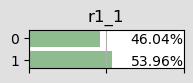
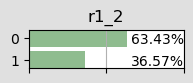
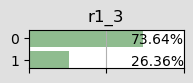
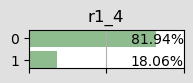
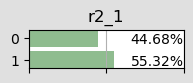
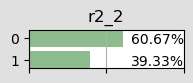
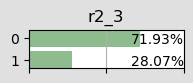
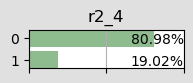
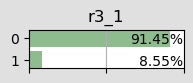
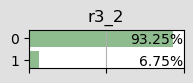
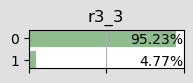
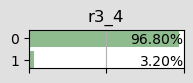
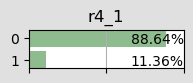
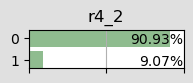
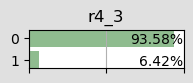
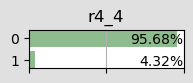
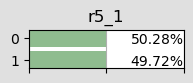
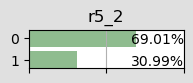
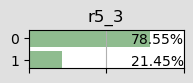
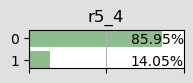
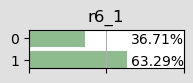
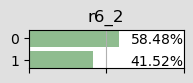
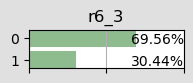
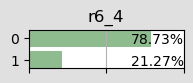
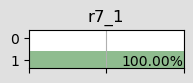
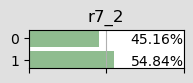
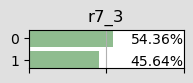
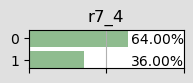
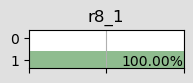
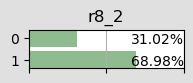
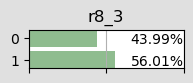
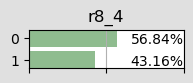
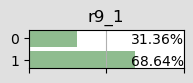
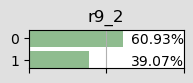
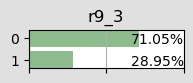
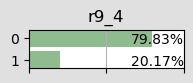
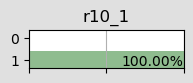
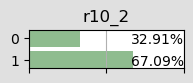
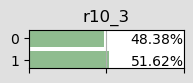
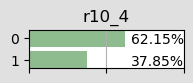
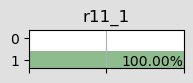
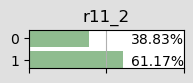
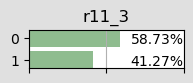
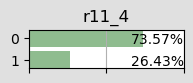
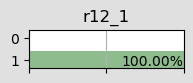
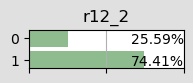
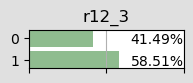
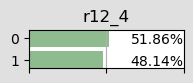
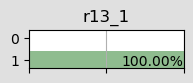
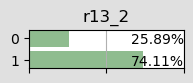
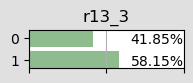
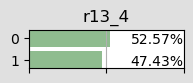
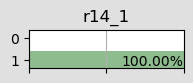
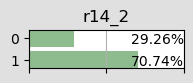
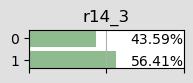
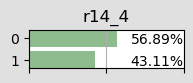
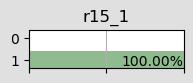
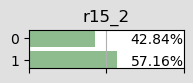
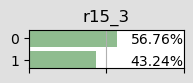
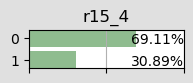
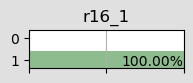
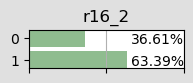
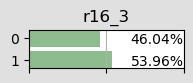
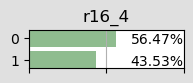
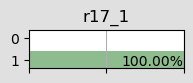
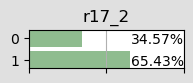
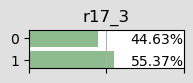
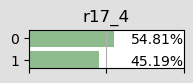
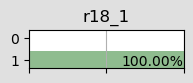
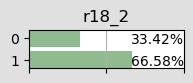
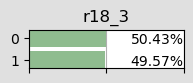
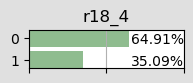
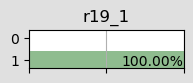
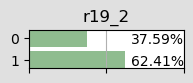
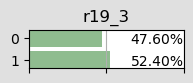
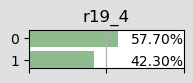
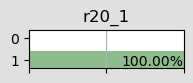
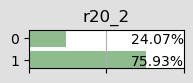
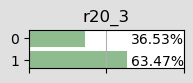
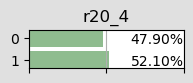
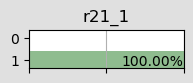
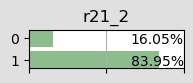
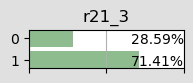
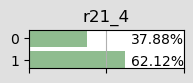
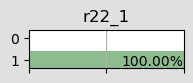
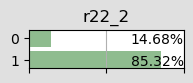
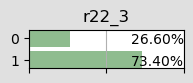
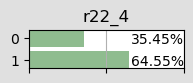
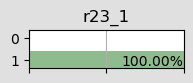
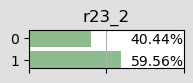
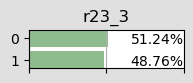
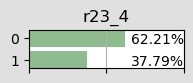
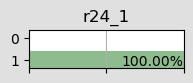
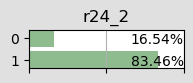
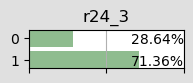
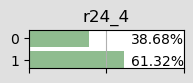
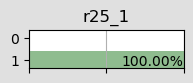
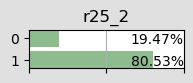
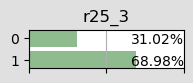
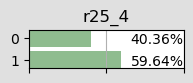
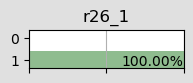
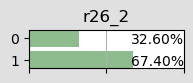
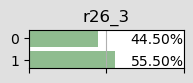
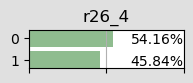
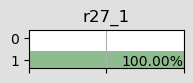
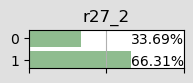
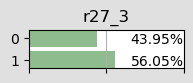
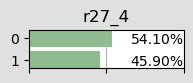
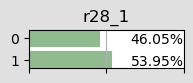
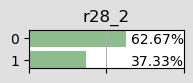
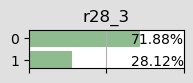
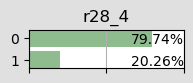
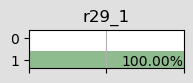
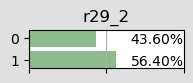
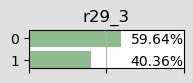
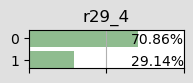
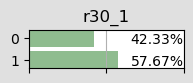
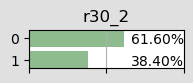
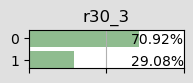
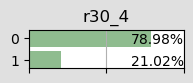
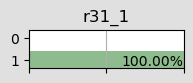
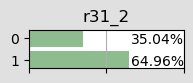
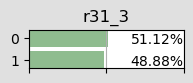
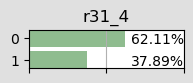
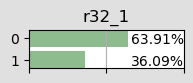
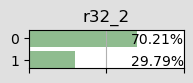
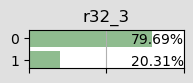
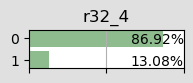
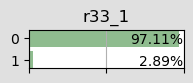
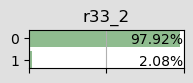
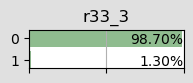
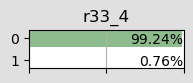
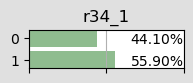
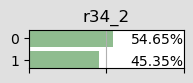
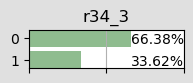
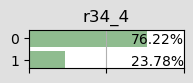
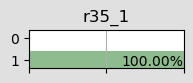
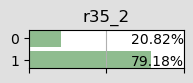
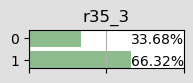
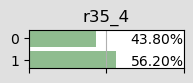
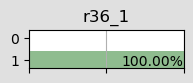
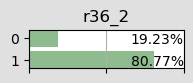
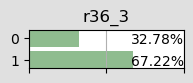
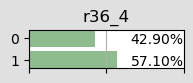
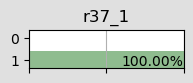
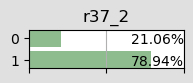
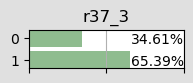
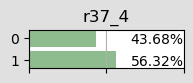
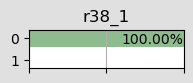
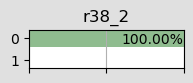
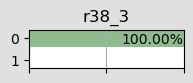
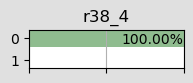
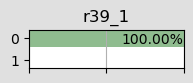
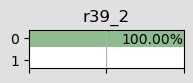
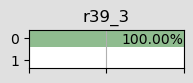
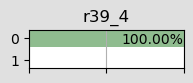
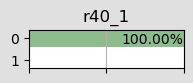
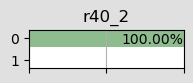
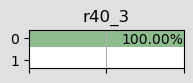
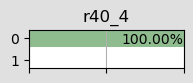
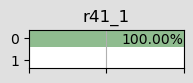
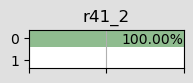
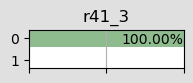
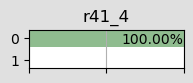
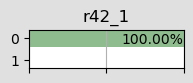
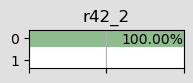
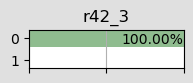
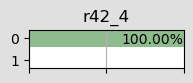
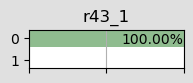
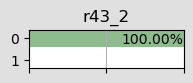
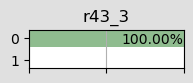
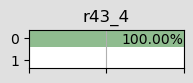
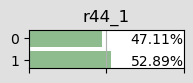
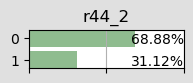
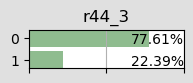
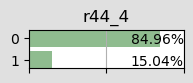
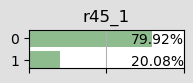
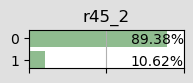
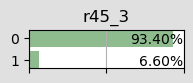
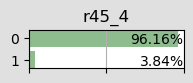
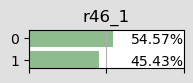
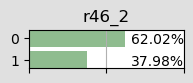
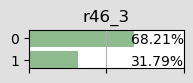
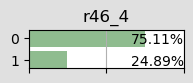
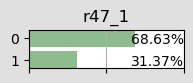
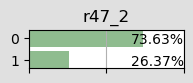
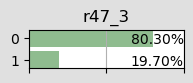
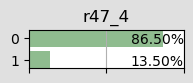
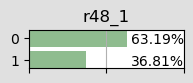
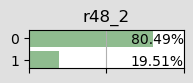
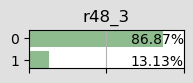
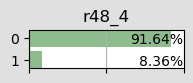
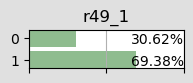
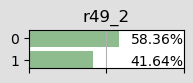
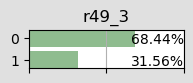
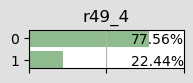
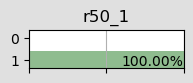
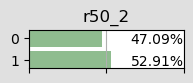
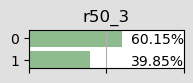
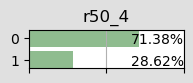
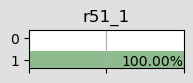
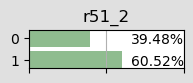
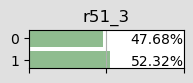
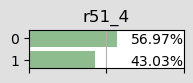
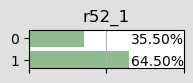
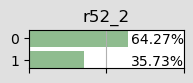
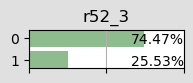
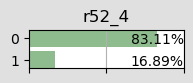
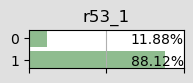
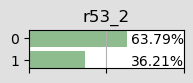
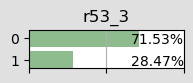
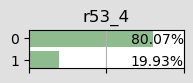
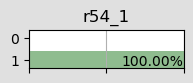
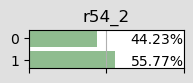
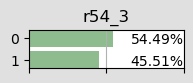
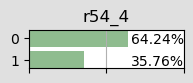
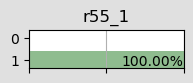
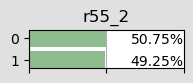
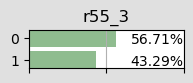
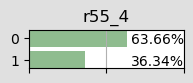
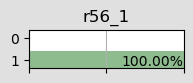
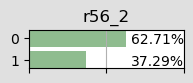
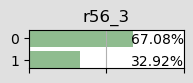
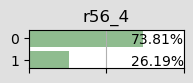
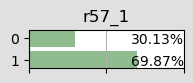
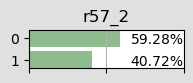
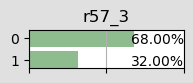
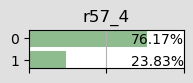
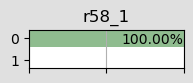
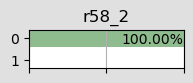
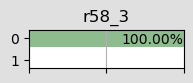
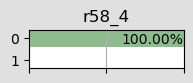
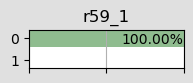
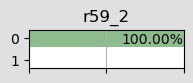
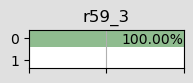
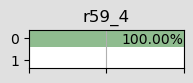
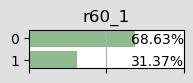
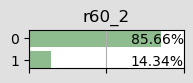
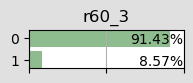
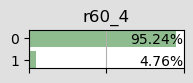
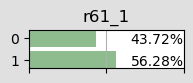
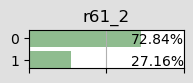
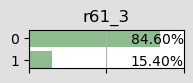
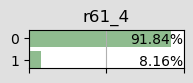
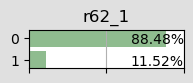
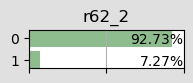
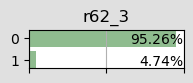
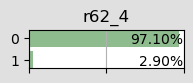
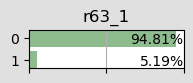
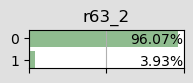
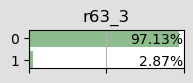
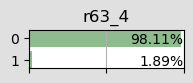
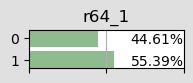
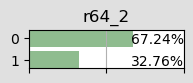
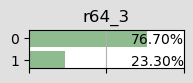
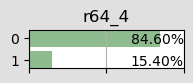
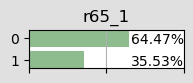
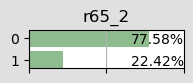
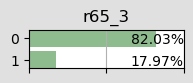
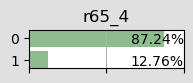

In [31]:
gnb.flow.clear()
for j in range(1,66):
    for i in [1, 2, 3, 4]:
        gnb.flow.add_html(gnb.getPosterior(ftts_dbn, target = "r"+str(j)+"_{}".format(i), evs={'r40_0':0, 'r40_1':0, 'r40_2':0, 'r40_3':0, 'r40_4':0}), "$P(a{})$".format(i))
gnb.flow.display()

In [32]:
now = datetime.now()

print("현재 : ", now)
print("현재 날짜 : ", now.date())
print("현재 시간 : ", now.time())
print("timestamp : ", now.timestamp())
print("년 : ", now.year)
print("월 : ", now.month)
print("일 : ", now.day)
print("시 : ", now.hour)
print("분 : ", now.minute)
print("초 : ", now.second)
print("마이크로초 : ", now.microsecond)
print("요일 : ", now.weekday())
print("문자열 변환 : ", now.strftime('%Y-%m-%d %H:%M:%S'))

현재 :  2023-11-23 19:26:25.063415
현재 날짜 :  2023-11-23
현재 시간 :  19:26:25.063415
timestamp :  1700735185.063415
년 :  2023
월 :  11
일 :  23
시 :  19
분 :  26
초 :  25
마이크로초 :  63415
요일 :  3
문자열 변환 :  2023-11-23 19:26:25


In [33]:
ftts_dbn_rooms =[e.split('_')[0]+('_') for e in ftts_dbn_nodes]

for node in dBN_nodes:
    dag_dBN.cpt(node)
    print(dag_dBN.cpt(node))

dag_dBN.cpt("r1_0").fillWith([0.74, 0.26, 0, 1])


dag_dBN.cpt("r53_0").names # 부모노드를 출력한다. 조건부확률의 조건


dag_dBN.cpt("r38_0").names


gnb.flow.clear()
for i in range(T):
    gnb.flow.add_html(gnb.getPosterior(unroll_dBN, target = "r1_{}".format(i), evs={}), "$P(a{})$".format(i))
gnb.flow.display()

sorted(ftts_dbn.names())